In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import torch
from tqdm import tqdm
import sys
from sklearn.metrics import roc_auc_score

sys.path.append('../../')

from configs.data_configs.half_moon import data_configs
from configs.model_configs.mTAN.half_moon import model_configs

from src.data_load.dataloader import create_data_loaders

from src.create_embeddings import create_embeddings

from src.data_load import split_strategy
from src.data_load.data_utils import prepare_data
from src.data_load.splitting_dataset import (
    ConvertingTrxDataset,  # TargetDataset
    DropoutTrxDataset,
    SplittingDataset,
    TargetEnumeratorDataset,
)
from src.data_load.dataloader import collate_splitted_rows, padded_collate
from torch.utils.data import DataLoader

In [2]:
conf = data_configs()
model_conf = model_configs()

In [3]:
train_loader, valid_loader = create_data_loaders(conf)

0it [00:00, ?it/s]

1000it [00:00, 9989.39it/s]


In [4]:
for batch in train_loader:
    i = 1

In [5]:
batch[1]

tensor([[768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781,
         782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795,
         796, 797, 798, 799],
        [  0,   1,   1,   1,   1,   0,   1,   0,   0,   0,   0,   0,   1,   0,
           0,   0,   0,   1,   1,   1,   0,   0,   1,   0,   0,   1,   0,   0,
           1,   1,   1,   0]])

In [6]:
df = pd.read_parquet(conf.train_path)

In [7]:
df.loc[768:775]

,0,1,target,col_id,event_time
768,[1.1323505286983444],[-0.5569506505071553],1,768,[1]
769,[-0.8951575043921682],[0.07943485996396277],0,769,[1]
770,[-0.03379252310783656],[0.49145316657422844],1,770,[1]
771,[1.2242626709718585],[-0.5049260467283473],1,771,[1]
772,[1.1906132413037187],[-0.5000881720817466],1,772,[1]
773,[1.0610098980627942],[0.5023663749002694],0,773,[1]
774,[-0.9626620445666096],[0.045293614301643595],0,774,[1]
775,[1.6918435590772827],[-0.2484266824587354],1,775,[1]


In [48]:
class SplittingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, splitter, target_col=None):
        self.base_dataset = base_dataset
        self.splitter = splitter
        self.target_col = target_col

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        row = self.base_dataset[idx]

        feature_arrays = row["feature_arrays"]
        local_date = row["event_time"]

        indexes = self.splitter.split(local_date)
        data = [{k: v[ix] for k, v in feature_arrays.items()} for ix in indexes]

        print(row)
        if self.target_col:
            target = row[self.target_col]
            target = int(target)
            return data, target
        return data

class TargetEnumeratorDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):     
        row, target = self.base_dataset[idx]
        data = [(x, (idx, target)) for x in row]
        return data

In [49]:
train_data, valid_data = prepare_data(conf)


0it [00:00, ?it/s]

1000it [00:00, 17037.97it/s]


In [50]:
train_dataset = SplittingDataset(
    train_data,
    split_strategy.create(**conf.train.split_strategy),
    conf.features.target_col,
)
#train_dataset = TargetEnumeratorDataset(train_dataset)

In [55]:
train_dataset[5]

{'0': array([1.27062626]), '1': array([-0.55024795]), 'target': 1, 'col_id': 6, 'event_time': array([1.]), 'feature_arrays': {'0': array([1.27062626]), '1': array([-0.55024795]), 'event_time': array([1.])}}


([{'0': array([1.27062626]),
   '1': array([-0.55024795]),
   'event_time': array([1.])}],
 1)

In [41]:
for i in range(600):
    target = train_data[i]['target']
    col_id = train_data[i]['col_id']

    if df['target'][col_id] != target:
        print(i)

In [36]:

#train_dataset = TargetEnumeratorDataset(train_dataset)
# train_dataset = TargetDataset(train_dataset)
# train_dataset = ConvertingTrxDataset(train_dataset)
# # не уверен что нам нужна история с дропаутом точек.
# # Но это выглядит неплохой аугментацией в целом
# train_dataset = DropoutTrxDataset(
#     train_dataset, trx_dropout=conf.train.dropout, seq_len=conf.train.max_seq_len
# )

1000it [00:00, 24586.47it/s]


In [37]:
train_dataset[4]

([{'0': array([-0.09861158]),
   '1': array([0.34683059]),
   'event_time': array([1.])}],
 1)

In [27]:
df.loc[:10]

,0,1,target,col_id,event_time
0,[1.2564677227403043],[-0.4982349528896482],1,0,[1]
1,[0.2913081239664366],[0.9861441999721128],0,1,[1]
2,[1.4242511091006964],[-0.4444525168552565],1,2,[1]
3,[0.01100900607838072],[0.979563567713171],0,3,[1]
4,[-0.9786544584194089],[0.10826022769732699],0,4,[1]
5,[-0.09861157901609519],[0.3468305853548797],1,5,[1]
6,[1.270626262075704],[-0.5502479499553864],1,6,[1]
7,[0.9225525798753054],[0.42749663565337603],0,7,[1]
8,[2.0702555839541024],[0.09803369024303199],1,8,[1]
9,[-1.0591006990827934],[0.5836934015362807],0,9,[1]


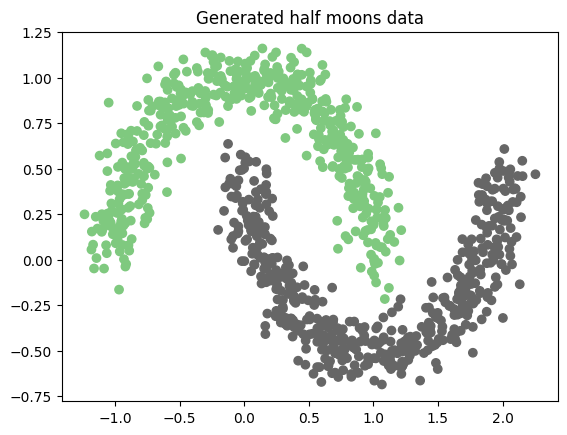

In [2]:
# CREATE DATA

# n_samples = 1000  # number of samples to generate
# noise = 0.1  # noise to add to sample locations
# x, y = datasets.make_moons(n_samples=n_samples, noise=noise)

# plt.scatter(*x.T, c=y, cmap=plt.cm.Accent)
# plt.title("Generated half moons data");

# df = pd.DataFrame(x)

# df['target'] = y
# df['col_id'] = df.index
# df['event_time'] = 1

# df[0] = df[0].apply(lambda x: [x])
# df[1] = df[1].apply(lambda x: [x])
# df['event_time'] = df['event_time'].apply(lambda x: [x])

# df.to_parquet('data/train_trx.parquet')

In [27]:
# MODELING Gives accuracy 1
# def model_factory():
#     return torch.nn.Sequential(
#         torch.nn.Linear(2, 10),
#         torch.nn.ReLU(),
#         torch.nn.Linear(10, 10),
#         torch.nn.ReLU(),
#         torch.nn.Linear(10, 2)
#     )

# device = torch.device('cpu')

# bl = model_factory().to(device)
# bl_opt = torch.optim.SGD(bl.parameters(), lr=0.1, momentum=0.9)
# xEnt = torch.nn.CrossEntropyLoss(ignore_index=-1).to(device)
# x_train, y_train = x[:800], y[:800]
# x_test, y_test = x[800:], y[800:]

# n_epochs = 500
# xt, yt = torch.Tensor(x_train).to(device), torch.LongTensor(y_train).to(device)
# for epoch in tqdm(range(n_epochs)):
#     # Standard forward/backward pass for training baseline
#     out = bl(xt)
#     loss = xEnt(out, yt)  # ignores the unlabeled data (-1)
#     bl_opt.zero_grad()
#     loss.backward()
#     bl_opt.step()

# bl.eval()
# bl_pred = bl(torch.Tensor(x_test))
# y_pred = bl_pred.argmax(dim=1)
# print("bl accuracy:", roc_auc_score(torch.LongTensor(y_test), y_pred))


100%|██████████| 500/500 [00:25<00:00, 19.95it/s]


bl accuracy: 1.0


In [55]:
y_test-y_pred.numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])